In [1]:
import wandb
import yaml
import numpy as np

from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
from src.tools import check_file_path

url="vincekillerz/base-traversability-estimation-v2/saved_model:v30"
name="asymformer"
run = wandb.init() 
            
artifact = run.use_artifact(url, type='model')
artifact_dir = artifact.download()
config = yaml.safe_load(open(check_file_path(artifact_dir, 'config.yaml')))
model_path = check_file_path(artifact_dir, 'trained_model.pth')
# Some standard imports


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: vincekillerz. Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact saved_model:v30, 126.27MB. 2 files... 
wandb:   2 of 2 files downloaded.  
Done. 0:0:0.3


In [2]:
from src.models.model_builder import model_builder


device = config['ml_orchestrator']['device']
model = model_builder(config['model_builder'])
model.to(device)

# load model
print(model_path)
model.load_state_dict(torch.load(model_path))
model.eval()

/home/gharib-ml/Desktop/master_thesis_v2/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/gharib-ml/Desktop/master_thesis_v2/src/models/asymformer/convnext.py:159: UserWarning: Overwriting convnext_tiny in registry with src.models.asymformer.convnext.convnext_tiny. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_tiny(pretrained=False,in_22k=False, **kwargs):
/home/gharib-ml/Desktop/master_thesis_v2/src/models/asymformer/convnext.py:168: UserWarning: Overwriting convnext_small in registry with src.models.asymformer.convnext.convnext_small. This is because the name being registered conflicts with an existing name. Please check if this is not expected.
  def convnext_small(pretrained=False,in_22k=False, **kwargs):
/hom

/home/gharib-ml/Desktop/master_thesis_v2/artifacts/saved_model:v30/trained_model.pth


B0_T(
  (down_sample_1): down_sample_block(
    (depth_stem): OverlapPatchEmbed(
      (proj): Conv2d(1, 32, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
    )
    (rgb_stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm()
    )
    (rgb_layer): Sequential(
      (0): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
        (pwconv2): Linear(in_features=384, out_features=96, bias=True)
        (drop_path): Identity()
      )
      (1): Block(
        (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
        (norm): LayerNorm()
        (pwconv1): Linear(in_features=96, out_features=384, bias=True)
        (act): GELU(approximate='none')
      

In [3]:
import torch
import torch.backends.cudnn as cudnn
import time
cudnn.benchmark = True

def benchmark(model, input_shape=(1024, 3, 512, 512), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    print("Warm up ...")
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()
    print("Start timing ...")
    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            pred_loc  = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
            if i%10==0:
                print('Iteration %d/%d, avg batch time %.2f ms'%(i, nruns, np.mean(timings)*1000))

    print("Input shape:", input_data.size())
    print('Average throughput: %.2f images/second'%(input_shape[0]/np.mean(timings)))


In [4]:
image = torch.randn(1, 3, 480, 640).to(device)
depth = torch.randn(1, 1, 480, 640).to(device)
torch_out = model(image,depth)

# Export the model
torch.onnx.export(model,               # model being run
                  (image,depth),                         # model input (or a tuple for multiple inputs)
                  name+'.onnx',   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                  input_names = ['input_rgb','input_depth'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input_rgb' : {0 : 'batch_size'},    # variable length axes
                                'input_depth' : {0 : 'batch_size'},
                                'output' : {0 : 'batch_size'}})

/home/gharib-ml/Desktop/master_thesis_v2/venv/lib/python3.8/site-packages/torch/onnx/symbolic_helper.py:833: UserWarning: You are trying to export the model with onnx:Resize for ONNX opset version 10. This operator might cause results to not match the expected results by PyTorch.
ONNX's Upsample/Resize operator did not match Pytorch's Interpolation until opset 11. Attributes to determine how to transform the input were added in onnx:Resize in opset 11 to support Pytorch's behavior (like coordinate_transformation_mode and nearest_mode).
We recommend using opset 11 and above for models using this operator.
  warnings.warn(


In [5]:
import onnx

onnx_model = onnx.load(name+".onnx")
onnx.checker.check_model(onnx_model)

In [6]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(name+".onnx", providers=[("CUDAExecutionProvider")])

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {
    ort_session.get_inputs()[0].name: to_numpy(image),
    ort_session.get_inputs()[1].name: to_numpy(depth)
    
}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-01, atol=1e-01)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

2024-05-24 12:07:06.800012219 [W:onnxruntime:, session_state.cc:1166 VerifyEachNodeIsAssignedToAnEp] Some nodes were not assigned to the preferred execution providers which may or may not have an negative impact on performance. e.g. ORT explicitly assigns shape related ops to CPU to improve perf.
2024-05-24 12:07:06.800033044 [W:onnxruntime:, session_state.cc:1168 VerifyEachNodeIsAssignedToAnEp] Rerunning with verbose output on a non-minimal build will show node assignments.


Exported model has been tested with ONNXRuntime, and the result looks good!


cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUDAExecutionProvider', 'CPUExecutionProvider']
cuda
['CUD

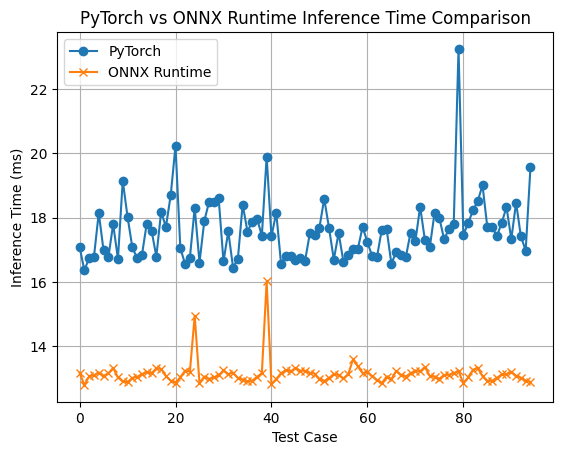

ONNX mean inference time: 13.14 ms
PyTorch mean inference time: 17.58 ms
ONNX is 1.34x faster than PyTorch!


In [7]:
import time
import matplotlib.pyplot as plt
# Lists to store execution times
pytorch_times = []
onnx_times = []
print(device)
for i in range(100):  # Conducting 10 tests
    # Generate random inputs

    x = torch.randn(1, 3, 480, 640, requires_grad=True).to(device)
    y = torch.randn(1, 1, 480, 640, requires_grad=True).to(device)
    model = model.to(device)
    # Measure PyTorch inference time
    torch.cuda.synchronize()
    start_time = time.time()
    with torch.no_grad():
        _ = model(x, y)  # Replace '_' with your model's actual output variable if you want to use it
    torch.cuda.synchronize()
    end_time = time.time()
    pytorch_times.append((end_time - start_time) * 1000)  # Convert to milliseconds

    # # Prepare inputs for ONNX Runtime
    # ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x), 
    #               ort_session.get_inputs()[1].name: to_numpy(y)}

    io_binding = ort_session.io_binding()
    io_binding.bind_input(
        name="input_rgb",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(x.shape),
        buffer_ptr=x.data_ptr(),
    )
    io_binding.bind_input(
        name="input_depth",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(y.shape),
        buffer_ptr=y.data_ptr(),
    )
    logit_output_shape = (1,1,480, 640)
    logit_output = torch.empty(logit_output_shape, dtype=torch.float32, device='cuda').contiguous()
    io_binding.bind_output(
        name="output",
        device_type="cuda",
        device_id=0,
        element_type=np.float32,
        shape=tuple(logit_output.shape),
        buffer_ptr=logit_output.data_ptr()
    )
    # Measure ONNX Runtime inference time

    start_time = time.time()
    _ = ort_session.run_with_iobinding(io_binding)  # Replace '_' with your ONNX model's actual output variable if you want to use it
 
    end_time = time.time()

    onnx_times.append((end_time - start_time) * 1000)  # Convert to milliseconds

pytorch_times = pytorch_times[5:]
onnx_times = onnx_times[5:]
# Plot comparison of execution times
plt.plot(pytorch_times, label='PyTorch', marker='o')
plt.plot(onnx_times, label='ONNX Runtime', marker='x')
plt.legend()
plt.xlabel('Test Case')
plt.ylabel('Inference Time (ms)')
plt.title('PyTorch vs ONNX Runtime Inference Time Comparison')
plt.grid(True)
plt.show()
# compare mean
pytorch_mean = np.mean(pytorch_times)
onnx_mean = np.mean(onnx_times)
print(f"ONNX mean inference time: {onnx_mean:.2f} ms")
print(f"PyTorch mean inference time: {pytorch_mean:.2f} ms")
print(f"ONNX is {pytorch_mean/onnx_mean:.2f}x faster than PyTorch!")

In [8]:
import onnx
import numpy as np

def is_overflow_in_fp16(tensor):
    original_data = np.asarray(tensor, dtype=np.float32)
    fp16_data = original_data.astype(np.float16)
    back_converted_data = fp16_data.astype(np.float32)

    diff = np.abs(back_converted_data - original_data)
    return np.any(diff > 0.001)

def is_truncated_in_fp16(tensor):
    original_data = np.asarray(tensor, dtype=np.float32)

    return np.any(np.abs(original_data) <= 0.0000001)  # Check if the FP16 weight is zero



model = onnx.load("asymformer.onnx")  # Load ONNX model
overflow_list=[]
for node in model.graph.node:
    if node.input:  # Check network layer which has 'input'
        for input_name in node.input:
            weight = next((init for init in model.graph.initializer if init.name == input_name), None)
            if weight is not None:  # Make sure the layer has 'weight'
                weights = onnx.numpy_helper.to_array(weight)
                if is_overflow_in_fp16(weights):
                    print(f"Node {node.name} ({node.op_type}): Weight overflow in fp16")
                    overflow_list.append(node.name)
                if is_truncated_in_fp16(weights):
                    print(f"Node {node.name} ({node.op_type}): Weight truncated in fp16")
                    overflow_list.append(node.name)

print('个数：',len(overflow_list))

Node /down_sample_1/depth_layer.1/attn/sr/Conv (Conv): Weight truncated in fp16
Node /down_sample_2/rgb_layer/rgb_layer.0/pwconv2/Add (Add): Weight overflow in fp16
Node /down_sample_2/rgb_layer/rgb_layer.2/Mul (Mul): Weight overflow in fp16
Node /down_sample_2/depth_layer.0/attn/kv/Add (Add): Weight truncated in fp16
Node /down_sample_2/depth_layer.1/attn/kv/Add (Add): Weight truncated in fp16
Node /down_sample_2/SCC/conv1/Conv (Conv): Weight overflow in fp16
Node /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization (BatchNormalization): Weight overflow in fp16
Node /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization (BatchNormalization): Weight overflow in fp16
Node /down_sample_3/rgb_stem/rgb_stem.1/Conv (Conv): Weight overflow in fp16
Node /down_sample_3/rgb_layer/rgb_layer.0/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_3/rgb_layer/rgb_layer.3/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_3/rgb_layer/rgb_layer.4/pwconv1/MatMul (Ma

/tmp/ipykernel_20173/2025094908.py:6: RuntimeWarning: overflow encountered in cast
  fp16_data = original_data.astype(np.float16)


Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/pwconv2/Add (Add): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.1/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/dwconv/Conv (Conv): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/norm/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/pwconv1/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/pwconv2/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/pwconv2/Add (Add): Weight overflow in fp16
Node /down_sample_4/rgb_layer/rgb_layer.2/Mul (Mul): Weight overflow in fp16
Node /down_sample_4/depth_layer.0/attn/q/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/depth_layer.0/attn/kv/MatMul (MatMul): Weight truncated in fp16
Node /down_sample_4/depth_layer.0/attn/kv/Add (Add): Weight trunc

In [9]:
import os
import tensorrt as trt

def build_engine(onnx_file_path, engine_file_path, overflow_list, flop=16):
    trt_logger = trt.Logger(trt.Logger.WARNING)  # trt.Logger.ERROR
    builder = trt.Builder(trt_logger)
    builder_config = builder.create_builder_config()
    
    network = builder.create_network(
        1 << (int)(trt.NetworkDefinitionCreationFlag.EXPLICIT_BATCH)
    )
    
    parser = trt.OnnxParser(network, trt_logger)
    # parse ONNX
    with open(onnx_file_path, 'rb') as model:
        if not parser.parse(model.read()):
            print('ERROR: Failed to parse the ONNX file.')
            for error in range(parser.num_errors):
                print(parser.get_error(error))
            return None
    print("Completed parsing ONNX file")

    # default = 1 for fixed batch size
    builder.max_batch_size = 1
    # set mixed flop computation for the best performance
    
    builder_config.set_flag(trt.BuilderFlag.FP16)

    if os.path.isfile(engine_file_path):
        try:ub
            os.remove(engine_file_path)
        except Exception:
            print("Cannot remove existing file: ",
                engine_file_path)

    print("Creating Tensorrt Engine")

    for layer in network:
        for layer_name in overflow_list:
            if layer_name in layer.name:
                layer.precision = trt.float32
                print(f'Network Layer: {layer.name}, {layer.type}, {layer.precision}, is_set: {layer.precision_is_set}')

    config = builder.create_builder_config()
    config.set_tactic_sources(1 << int(trt.TacticSource.CUBLAS))
    config.max_workspace_size = 2 << 30
    config.set_flag(trt.BuilderFlag.FP16)
    config.set_flag(trt.BuilderFlag.STRICT_TYPES)

    print('config.flags: ', config.flags)
    profile = builder.create_optimization_profile()
    profile.set_shape("input_rgb", (1, 3, 480, 640), (1, 3, 480, 640),(1, 3, 480, 640))   
    profile.set_shape("input_depth", (1, 1, 480, 640), (1, 1, 480, 640),(1, 1, 480, 640))    
    config.add_optimization_profile(profile)
    engine = builder.build_engine(network, config)
    with open(engine_file_path, "wb") as f:
        f.write(engine.serialize())
    print("Serialized Engine Saved at: ", engine_file_path)
    return engine

In [10]:
ONNX_SIM_MODEL_PATH = 'asymformer.onnx'
TENSORRT_ENGINE_PATH_PY = 'asymformer.engine'

build_engine(ONNX_SIM_MODEL_PATH, TENSORRT_ENGINE_PATH_PY, overflow_list)

[05/24/2024-12:07:20] [TRT] [W] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[05/24/2024-12:07:20] [TRT] [W] onnx2trt_utils.cpp:400: One or more weights outside the range of INT32 was clamped
Completed parsing ONNX file


/tmp/ipykernel_20173/2165082848.py:24: DeprecationWarning: Use network created with NetworkDefinitionCreationFlag::EXPLICIT_BATCH flag instead.
  builder.max_batch_size = 1


Creating Tensorrt Engine
Network Layer: /down_sample_1/depth_layer.1/attn/sr/Conv, LayerType.CONVOLUTION, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_layer/rgb_layer.0/pwconv2/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/rgb_layer/rgb_layer.2/Mul, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/depth_layer.0/attn/kv/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/depth_layer.1/attn/kv/Add, LayerType.ELEMENTWISE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/SCC/conv1/Conv, LayerType.CONVOLUTION, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization, LayerType.SCALE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_2/SCC/cross_atten/bn_x2/BatchNormalization, LayerType.SCALE, DataType.FLOAT, is_set: True
Network Layer: /down_sample_3/rgb_stem/rgb_stem.1/Conv, LayerType.CONVOLUTION, DataType

/tmp/ipykernel_20173/2165082848.py:46: DeprecationWarning: Use set_memory_pool_limit instead.
  config.max_workspace_size = 2 << 30
/tmp/ipykernel_20173/2165082848.py:55: DeprecationWarning: Use build_serialized_network instead.
  engine = builder.build_engine(network, config)


[05/24/2024-12:07:20] [TRT] [W] Detected layernorm nodes in FP16: /down_sample_1/rgb_stem/rgb_stem.1/Sub, /down_sample_1/rgb_stem/rgb_stem.1/Pow, /down_sample_1/rgb_stem/rgb_stem.1/ReduceMean_1, /down_sample_1/rgb_stem/rgb_stem.1/Add, /down_sample_1/rgb_stem/rgb_stem.1/Sqrt, /down_sample_1/rgb_stem/rgb_stem.1/Div, /down_sample_1/depth_stem/norm/Sub, /down_sample_1/rgb_stem/rgb_stem.1/Mul, /down_sample_1/depth_stem/norm/Pow, /down_sample_1/rgb_stem/rgb_stem.1/Add_1, /down_sample_1/depth_stem/norm/ReduceMean_1, /down_sample_1/depth_stem/norm/Add, /down_sample_1/depth_stem/norm/Sqrt, /down_sample_1/depth_stem/norm/Div, /down_sample_1/rgb_layer/rgb_layer.0/norm/Sub, /down_sample_1/depth_stem/norm/Mul, /down_sample_1/rgb_layer/rgb_layer.0/norm/Pow, /down_sample_1/depth_stem/norm/Add_1, /down_sample_1/rgb_layer/rgb_layer.0/norm/ReduceMean_1, /down_sample_1/rgb_layer/rgb_layer.0/norm/Add, /down_sample_1/depth_layer.0/norm1/Sub, /down_sample_1/rgb_layer/rgb_layer.0/norm/Sqrt, /down_sample_1/de

Running TensorRT inference
Reading engine from file asymformer.engine


/tmp/ipykernel_20173/4247535250.py:27: DeprecationWarning: Use get_tensor_name instead.
  context.set_binding_shape(engine.get_binding_index("input_rgb"),img_rgb.shape)
/tmp/ipykernel_20173/4247535250.py:27: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(engine.get_binding_index("input_rgb"),img_rgb.shape)
/tmp/ipykernel_20173/4247535250.py:28: DeprecationWarning: Use get_tensor_name instead.
  context.set_binding_shape(engine.get_binding_index("input_depth"),img_depth.shape)
/tmp/ipykernel_20173/4247535250.py:28: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(engine.get_binding_index("input_depth"),img_depth.shape)
/tmp/ipykernel_20173/4247535250.py:32: DeprecationWarning: Use get_tensor_name instead.
  binding_idx = engine.get_binding_index(binding)
/tmp/ipykernel_20173/4247535250.py:33: DeprecationWarning: Use get_tensor_shape instead.
  size = trt.volume(context.get_binding_shape(binding_idx))
/tmp/ipykernel_20173/42475352

(1, 1, 480, 640)


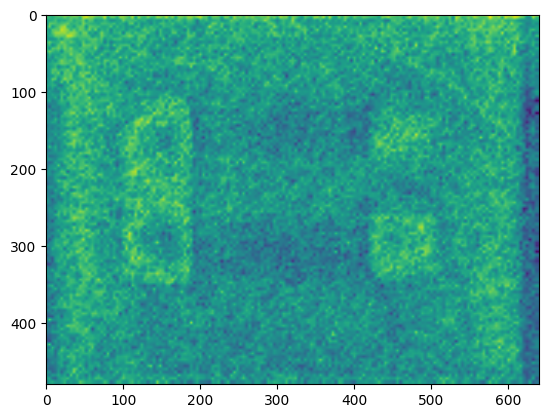

In [11]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt

import matplotlib.pyplot as plt
from PIL import Image

TRT_LOGGER = trt.Logger()

# Filenames of TensorRT plan file and input/output images.
engine_file = "asymformer.engine"



def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())
def infer(engine):
    img_rgb =np.random.rand(1,3,480, 640).astype(np.float32)
    img_depth =np.random.rand(1,1,480, 640).astype(np.float32)
    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input_rgb"),img_rgb.shape)
        context.set_binding_shape(engine.get_binding_index("input_depth"),img_depth.shape)
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                if str(binding)=="input_rgb":
                    input_buffer = np.ascontiguousarray(img_rgb)
                elif str(binding) =='input_depth':
                    input_buffer = np.ascontiguousarray(img_depth)
                input_memory = cuda.mem_alloc(input_buffer.nbytes)
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))

        stream = cuda.Stream()
        # Transfer input data to the GPU.
        cuda.memcpy_htod_async(input_memory, input_buffer, stream)
        # Run inference
        context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
        # Transfer prediction output from the GPU.
        cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
        # Synchronize the stream
        stream.synchronize()
        output_buffer = np.reshape(output_buffer,(1,1,480,640))
        return output_buffer


print("Running TensorRT inference")
with load_engine(engine_file) as engine:
    o = infer(engine)
    print(o.shape)
    plt.imshow(o[0][0])

In [12]:
import numpy as np
import os
import pycuda.driver as cuda
import pycuda.autoinit
import tensorrt as trt
import time

import matplotlib.pyplot as plt
from PIL import Image

TRT_LOGGER = trt.Logger()

# Filenames of TensorRT plan file and input/output images.
engine_file = "asymformer.engine"

def load_engine(engine_file_path):
    assert os.path.exists(engine_file_path)
    print("Reading engine from file {}".format(engine_file_path))
    with open(engine_file_path, "rb") as f, trt.Runtime(TRT_LOGGER) as runtime:
        return runtime.deserialize_cuda_engine(f.read())

def infer(engine):
    img_rgb = np.random.rand(1, 3, 480, 640).astype(np.float32)
    img_depth = np.random.rand(1, 1, 480, 640).astype(np.float32)
    with engine.create_execution_context() as context:
        # Set input shape based on image dimensions for inference
        context.set_binding_shape(engine.get_binding_index("input_rgb"), img_rgb.shape)
        context.set_binding_shape(engine.get_binding_index("input_depth"), img_depth.shape)
        # Allocate host and device buffers
        bindings = []
        for binding in engine:
            binding_idx = engine.get_binding_index(binding)
            size = trt.volume(context.get_binding_shape(binding_idx))
            dtype = trt.nptype(engine.get_binding_dtype(binding))
            if engine.binding_is_input(binding):
                if str(binding) == "input_rgb":
                    input_buffer = np.ascontiguousarray(img_rgb)
                elif str(binding) == 'input_depth':
                    input_buffer = np.ascontiguousarray(img_depth)
                input_memory = cuda.mem_alloc(input_buffer.nbytes)
                bindings.append(int(input_memory))
            else:
                output_buffer = cuda.pagelocked_empty(size, dtype)
                output_memory = cuda.mem_alloc(output_buffer.nbytes)
                bindings.append(int(output_memory))

        stream = cuda.Stream()
        # Transfer input data to the GPU.
        cuda.memcpy_htod_async(input_memory, input_buffer, stream)
        # Run inference
        start_time = time.time()
        context.execute_async_v2(bindings=bindings, stream_handle=stream.handle)
        # Transfer prediction output from the GPU.
        cuda.memcpy_dtoh_async(output_buffer, output_memory, stream)
        # Synchronize the stream
        stream.synchronize()
        end_time = time.time()
        inference_time = end_time - start_time
        return output_buffer, inference_time

print("Running TensorRT inference")
with load_engine(engine_file) as engine:
    total_inference_time = 0
    for _ in range(100):
        _, inference_time = infer(engine)
        total_inference_time += inference_time
    avg_inference_time = total_inference_time / 100 * 1000
    print(f"Average inference time over 100 rounds: {avg_inference_time:.4f} ms")
    o, _ = infer(engine)
    print(o.shape)
    plt.imshow(o[0][0])

Running TensorRT inference
Reading engine from file asymformer.engine


/tmp/ipykernel_20173/1266494184.py:27: DeprecationWarning: Use get_tensor_name instead.
  context.set_binding_shape(engine.get_binding_index("input_rgb"), img_rgb.shape)
/tmp/ipykernel_20173/1266494184.py:27: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(engine.get_binding_index("input_rgb"), img_rgb.shape)
/tmp/ipykernel_20173/1266494184.py:28: DeprecationWarning: Use get_tensor_name instead.
  context.set_binding_shape(engine.get_binding_index("input_depth"), img_depth.shape)
/tmp/ipykernel_20173/1266494184.py:28: DeprecationWarning: Use set_input_shape instead.
  context.set_binding_shape(engine.get_binding_index("input_depth"), img_depth.shape)
/tmp/ipykernel_20173/1266494184.py:32: DeprecationWarning: Use get_tensor_name instead.
  binding_idx = engine.get_binding_index(binding)
/tmp/ipykernel_20173/1266494184.py:33: DeprecationWarning: Use get_tensor_shape instead.
  size = trt.volume(context.get_binding_shape(binding_idx))
/tmp/ipykernel_20173/1266

Average inference time over 100 rounds: 8.8594 ms
(307200,)


IndexError: invalid index to scalar variable.